#【刷榜记录】

训练集: 99.9799%

测试集: 99.3467%

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch import nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset #, random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# 导入数据

In [2]:
dataset_root = r'TibetanMNIST.npz'

raw_data = np.load(dataset_root)
image_data, label_data = raw_data['image'][..., None], raw_data['label'].astype('int64')

# 定义TibetanMnist类

In [3]:
class TibetanMnist(Dataset):

    def __init__(self, img=image_data, target=label_data, transform=None):
        self.img = image_data
        self.target = label_data
        self.transform = transform
        
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img = self.img[idx, ...]
        img = img/255
        label = self.target[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# 训练网络函数

In [4]:
def train_model(model, criterion, optimizer, epoch_num, train_dataloader, test_dataloader):

    train_loss_all = []
    train_acc_all = []
    eval_loss_all = []
    eval_acc_all = []

    for epo in range(epoch_num):

        train_loss = 0
        train_acc = 0
        model.train()

        for idx, (img, label) in enumerate(train_dataloader):

            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(img)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, pred = output.max(dim = 1)
            num_correct = (pred == label).sum().item()
            acc = num_correct / img.shape[0]
            train_acc += acc
            # print('train epoch: {}, idx: {}, idx_acc: {}'.format(epo, idx, acc))

        # 在测试集上检验效果
        eval_loss = 0
        eval_acc = 0
        model.eval() 
        with torch.no_grad():
            for idx, (img, label) in enumerate(test_dataloader):
                
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                loss = criterion(output, label)
                eval_loss += loss.item()
                _, pred = output.max(dim = 1)
                num_correct = (pred == label).sum().item()
                acc = num_correct / img.shape[0]
                eval_acc += acc            
                # print('test epoch: {}, idx: {}, idx_acc: {}'.format(epo, idx, acc))

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        eval_loss /= len(test_dataloader)
        eval_acc /= len(test_dataloader)

        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        eval_loss_all.append(eval_loss)
        eval_acc_all.append(eval_acc)

        print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'.format(
            epo, train_loss, train_acc, eval_loss, eval_acc))

    return train_loss_all, train_acc_all, eval_loss_all, eval_acc_all    

# 绘图函数

In [5]:
def plot_result(train, test, title, ylabel, xlabel='Epoch'):
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title(title)
    plt.ylabel('ylabel')
    plt.xlabel(xlabel)

# 载入数据集

In [6]:
tibetan_mnist_dataset = TibetanMnist(
    img=image_data, target=label_data, transform=transforms.ToTensor())

dataset_size = len(tibetan_mnist_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))

random_seed = 2018 #可以改成随机种子
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = DataLoader(tibetan_mnist_dataset, batch_size=128, sampler=train_sampler)
test_dataloader = DataLoader(tibetan_mnist_dataset, batch_size=128, sampler=test_sampler)

# 网络结构

In [7]:
class FCN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=128,            
                kernel_size=3           
            ),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128, 
                kernel_size=3
            ),     
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(       
            nn.Conv2d(
                in_channels=128,
                out_channels=128, 
                kernel_size=3
            ),     
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128, 
                kernel_size=3
            ),     
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=64, 
                kernel_size=3
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.classifer = nn.Sequential(       
            nn.Conv2d(
                in_channels=64,
                out_channels=10, 
                kernel_size=3
            ),  
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifer(x)
        return x.squeeze()      

# 训练参数

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fcn = FCN().to(device)
criterion_fcn = nn.CrossEntropyLoss().to(device)
optimizer_fcn = optim.Adam(fcn.parameters(), lr=1e-3)

# 开始训练

In [9]:
train_loss_all, train_acc_all, eval_loss_all, eval_acc_all = train_model(
    model=fcn, 
    criterion=criterion_fcn,
    optimizer=optimizer_fcn,
    epoch_num=50,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader
)

epoch: 0, Train Loss: 0.391538, Train Acc: 0.912388, Eval Loss: 0.103998, Eval Acc: 0.980569
epoch: 1, Train Loss: 0.079654, Train Acc: 0.980329, Eval Loss: 0.082858, Eval Acc: 0.976954
epoch: 2, Train Loss: 0.057129, Train Acc: 0.984724, Eval Loss: 0.046735, Eval Acc: 0.985212
epoch: 3, Train Loss: 0.033428, Train Acc: 0.991908, Eval Loss: 0.046371, Eval Acc: 0.986429
epoch: 4, Train Loss: 0.027530, Train Acc: 0.992606, Eval Loss: 0.078786, Eval Acc: 0.972300
epoch: 5, Train Loss: 0.022378, Train Acc: 0.994559, Eval Loss: 0.036293, Eval Acc: 0.991071
epoch: 6, Train Loss: 0.010537, Train Acc: 0.997768, Eval Loss: 0.033158, Eval Acc: 0.990703
epoch: 7, Train Loss: 0.006736, Train Acc: 0.998814, Eval Loss: 0.043634, Eval Acc: 0.985491
epoch: 8, Train Loss: 0.008384, Train Acc: 0.997838, Eval Loss: 0.033254, Eval Acc: 0.989587
epoch: 9, Train Loss: 0.004466, Train Acc: 0.999442, Eval Loss: 0.028823, Eval Acc: 0.992656
epoch: 10, Train Loss: 0.006204, Train Acc: 0.998675, Eval Loss: 0.029

# 保存模型

In [10]:
torch.save(fcn, 'fcn.pkl')
torch.save(fcn.state_dict(), 'fcn_params.pkl')

C:\Users\m\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 绘图

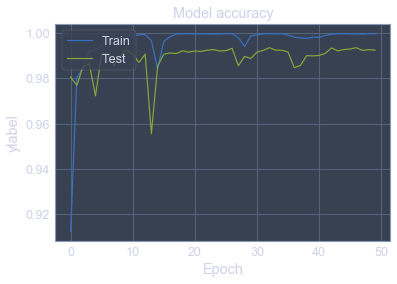

In [11]:
plot_result(train_acc_all, eval_acc_all, 'Model accuracy', 'Accuracy')

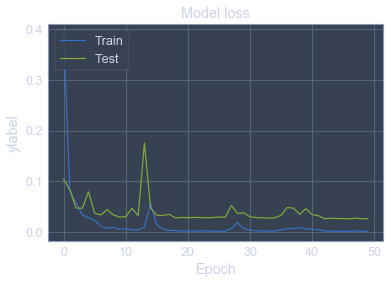

In [12]:
plot_result(train_loss_all, eval_loss_all, 'Model loss', 'Loss')